In [16]:
#initial version
#created on 08.12.2020 by kaarel
#Inspired by https://www.kaggle.com/furiousx7/xgboost-time-series
#Randomize train set as time added as features
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance, plot_tree, XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

train_data = pd.read_csv('../Data/Train_Plant1_added_features.csv')


In [17]:
def create_features(in_data):
    in_data['DATE_TIME'] = pd.to_datetime(in_data['DATE_TIME'])
    in_data["DATE"] = in_data['DATE_TIME'].dt.date
    in_data["HOUR"] = in_data['DATE_TIME'].dt.hour
    in_data["MINUTE"] = in_data['DATE_TIME'].dt.minute
    in_data["DAY_OF_YEAR"] = in_data['DATE_TIME'].dt.dayofyear
    in_data["DAY_OF_WEEK"] = in_data['DATE_TIME'].dt.dayofweek
    in_data["MONTH"] = in_data['DATE_TIME'].dt.month
    in_data["DAY_OF_MONTH"] = in_data['DATE_TIME'].dt.day


train_columns = [
       'HOUR',
       'MINUTE',
       'DAY_OF_YEAR',
       'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1',
       'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1',
       'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_1',
       'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1',
       'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3',
       'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3',
       'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3',
       'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3',
       'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_3']


In [18]:
#
from sklearn.model_selection import train_test_split

create_features(train_data)
#split_date = pd.to_datetime('06-01-2020')
#pred_train = train_data.loc[train_data.DATE <= split_date].copy()
#pred_test = train_data.loc[train_data.DATE > split_date].copy()

pred_train, pred_test, train_y, test_y = train_test_split(train_data[train_columns], train_data['DC_POWER'])

In [19]:
import numpy as np
predict_column = 'DC_POWER'
prediction_models = []
reg = xgb.XGBRegressor(n_estimators=10000)
reg.fit(pred_train, train_y,
        eval_set=[(pred_train, train_y), (pred_test, test_y)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=True)
prediction_models.append(reg)

[0]	validation_0-rmse:3130.05005	validation_1-rmse:3143.89893
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:2401.27856	validation_1-rmse:2418.91602
[2]	validation_0-rmse:1870.76733	validation_1-rmse:1890.09485
[3]	validation_0-rmse:1517.66016	validation_1-rmse:1541.98511
[4]	validation_0-rmse:1251.29614	validation_1-rmse:1274.67835
[5]	validation_0-rmse:1072.31946	validation_1-rmse:1093.37708
[6]	validation_0-rmse:959.25018	validation_1-rmse:979.00134
[7]	validation_0-rmse:873.08160	validation_1-rmse:893.75299
[8]	validation_0-rmse:801.64209	validation_1-rmse:819.40784
[9]	validation_0-rmse:762.89642	validation_1-rmse:777.76770
[10]	validation_0-rmse:715.68781	validation_1-rmse:732.73163
[11]	validation_0-rmse:693.44665	validation_1-rmse:711.04169
[12]	validation_0-rmse:680.34875	validation_1-rmse:697.46564
[13]	validation_0-rmse:665.25873	validation_1-

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

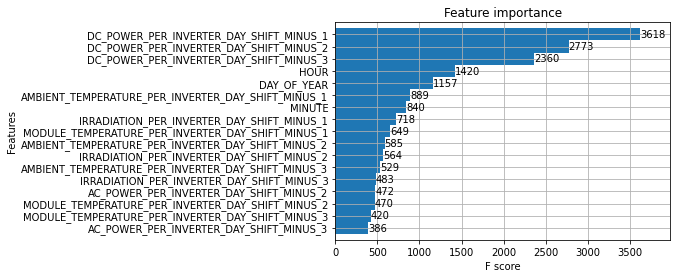

In [20]:
xgb.plot_importance(reg, height=1)


In [21]:
#Features selection try all combinations in a set and choose best set
from itertools import combinations
def get_feature_set_rmse(train_columns):
    k = len(train_columns)-1
    print(k)
    new_train_columns = list(combinations(train_columns,k))
    prediction_models = []
    for t in new_train_columns:
        reg = xgb.XGBRegressor(n_estimators=10000)
        reg.fit(pred_train[np.asarray(t)], train_y,
            eval_set=[(pred_train[np.asarray(t)], train_y), (pred_test[np.asarray(t)], test_y)],
            early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
            verbose=False)
        test_predictions = reg.predict(pred_test[np.asarray(t)])
        RMSE = mean_squared_error(test_y, test_predictions)
        prediction_models.append(RMSE)
        print(RMSE, t)
    return (prediction_models, new_train_columns)


In [22]:
best_models = []
initial_columns = train_columns.copy()
for k in np.arange(len(initial_columns),1,-1):
    (prediction_models, new_train_columns) = get_feature_set_rmse(initial_columns)
    current_loop_best = np.argmin(prediction_models)
    best_models.append((prediction_models[current_loop_best], new_train_columns[current_loop_best]))
    initial_columns = new_train_columns[current_loop_best]
    print('BEST:',prediction_models[current_loop_best],new_train_columns[current_loop_best])

16
107020.73943843458 ('HOUR', 'MINUTE', 'DAY_OF_YEAR', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_2', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3', 'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3')
98172.92500850071 ('HOUR', 'MINUTE', 'DAY_OF_YEAR', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AC_POWER_PER_INVERTER_DA

In [ ]:
#FINDING BETTER HYPERPARAMETERS

train_data = pd.read_csv('../Data/Train_Plant1_added_features.csv')
create_features(train_data)

#BEST 1 plant model
model_train_columns = ['HOUR', 'MINUTE', 'DAY_OF_YEAR', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_3']

#### Create X and Y training data here.....
X = train_data[model_train_columns]
Y = train_data[predict_column]


#https://www.kaggle.com/jayatou/xgbregressor-with-gridsearchcv
# Various hyper-parameters to tune
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #best set identified
              'objective':['reg:linear'],
              'learning_rate': [.01],
              'max_depth': [7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X,
         Y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)




In [23]:
from calculate_model_statistics import calculate_RMSE_MSE


#PERFORMANCE VALIDATION ON TEST DATA
train_data = pd.read_csv('../Data/Train_Plant1_added_features.csv')
test_data = pd.read_csv('../Data/Test_Plant1_added_features.csv')

#BEST 1 plant model
model_train_columns = ['HOUR', 'MINUTE', 'DAY_OF_YEAR', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_3']

#DO DATA PREP FOR TRAIN
create_features(train_data)
pred_train, pred_test, train_y, test_y = train_test_split(train_data[train_columns], train_data['DC_POWER'])

#TRAIN BEST MODEL AGAIN
reg_final = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.01, max_depth =  7, min_child_weight =  4, n_estimators = 500, nthread =  4, objective = 'reg:linear', subsample = 0.7)
reg_final.fit(pred_train[model_train_columns], train_y,
        eval_set=[(pred_train[model_train_columns], train_y), (pred_test[model_train_columns], test_y)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=True)

#CREATE TEST_DATA FEATURES
create_features(test_data)

#DO TEST DATA PREDICTIONS
test_predictions = reg_final.predict(test_data[model_train_columns])

#INDIVIDUAL PERIODS PREDICTIONS
calculate_RMSE_MSE(test_data, predict_column, test_predictions)

[23:18:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4171.54883	validation_1-rmse:4231.64941
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:4134.86865	validation_1-rmse:4194.24853
[2]	validation_0-rmse:4098.70508	validation_1-rmse:4157.35205
[3]	validation_0-rmse:4063.46631	validation_1-rmse:4121.48242
[4]	validation_0-rmse:4029.53174	validation_1-rmse:4087.07153
[5]	validation_0-rmse:3994.12744	validation_1-rmse:4051.03589
[6]	validation_0-rmse:3958.11108	validation_1-rmse:4014.51880
[7]	validation_0-rmse:3922.16992	validation_1-rmse:3978.12671
[8]	validation_0-rmse:3886.66821	validation_1-rmse:3942.04761
[9]	validation_0-rmse:3852.04248	validation_1-rmse:3906.73755
[10]	validation_0-rmse:3818.54150	validation